In [1]:
import subprocess

import numpy as np
import matplotlib.pyplot as plt

# create example mask

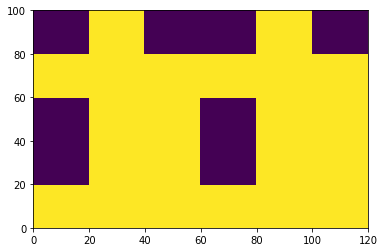

In [2]:
ni = 120
nj = 100

mask = np.ones((nj, ni))
mask[nj//5:3*nj//5,0:ni//6] = 0
mask[nj//5:3*nj//5,3*ni//6:4*ni//6] = 0
mask[4*nj//5:nj,0:ni//6] = 0
mask[4*nj//5:nj,2*ni//6:4*ni//6] = 0
mask[4*nj//5:nj,5*ni//6:ni] = 0

plt.pcolormesh(mask)
plt.show()

# create sparse connectivity matrix

In [3]:
def ind_nd_wrap(mask_shape, ind_nd):
    ind_nd_list = list(ind_nd)
    if ind_nd_list[-1] < 0:
        ind_nd_list[-1] += mask_shape[-1]
    if ind_nd_list[-1] >= mask_shape[-1]:
        ind_nd_list[-1] -= mask_shape[-1]
    if ind_nd_list[-2] >= mask_shape[-2]:
        ind_nd_list[-1] = mask_shape[-1] - 1 - ind_nd_list[-1]
        ind_nd_list[-2] = 2 * mask_shape[-2] - 1 - ind_nd_list[-2]
#     if ind_nd_list[-2] < 0:
#         ind_nd_list[-1] = mask_shape[-1] - 1 - ind_nd_list[-1]
#         ind_nd_list[-2] = -1 - ind_nd_list[-2]
    return tuple(ind_nd_list)

def tuple_sum(tup1, tup2):
    return tuple(map(sum, zip(tup1, tup2)))

def gen_conn_nd(mask, ind_nd):
    if mask[ind_nd] == 0:
        return set()
    ind_nd_offsets = []
    # from shallower layer
    if mask.ndim == 3 and ind_nd[-3] > 0:
        ind_nd_offsets.extend([
            (-1, -1, 0),
            (-1, 0, -1),
            (-1, 0, 0),
            (-1, 0, 1),
            (-1, 1, 0),            
        ])
    # from same layer
    ind_nd_offsets.extend([
#         (0, -2, 0),
        (0, -1, -1),
        (0, -1, 0),
        (0, -1, 1),
#         (0, 0, -2),
        (0, 0, -1),
        (0, 0, 0),
        (0, 0, 1),
#         (0, 0, 2),
        (0, 1, -1),
        (0, 1, 0),
        (0, 1, 1),
#         (0, 2, 0),
    ])
    # from deeper layer
    if mask.ndim == 3 and ind_nd[-3] < mask.shape[-3] - 1:
        ind_nd_offsets.extend([
            (1, -1, 0),
            (1, 0, -1),
            (1, 0, 0),
            (1, 0, 1),
            (1, 1, 0),
        ])

    ret_val = set()
    for ind_nd_offset in ind_nd_offsets:
        ind_nd_conn = tuple_sum(ind_nd, ind_nd_offset[-mask.ndim:])
        ind_nd_conn = ind_nd_wrap(mask.shape, ind_nd_conn)

        # only proceed if ind_nd_conn entries are in bounds
        for n in range(mask.ndim):
            if ind_nd_conn[n] < 0 or ind_nd_conn[n] >= mask.shape[n]:
                break
        else:
            if mask[ind_nd_conn]:
                ret_val.update({ind_nd_conn})

    return ret_val


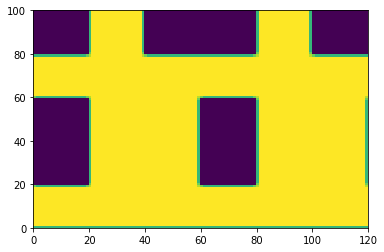

9

In [4]:
conn_nd = np.empty(mask.shape, np.object)
conn_nd_cnt = np.zeros(mask.shape, dtype=np.int32)
for ind_nd, maskval in np.ndenumerate(mask):
    conn_nd[ind_nd] = gen_conn_nd(mask, ind_nd)
    conn_nd_cnt[ind_nd] = len(conn_nd[ind_nd])

plt.pcolormesh(conn_nd_cnt)
plt.show()

conn_nd_cnt.max()

In [5]:
def gen_conn2_nd(mask, ind_nd):
    if mask[ind_nd] == 0:
        return set()
    ret_val = set()
    for ind2_nd in conn_nd[ind_nd]:
        ret_val.update(conn_nd[ind2_nd])
    return ret_val


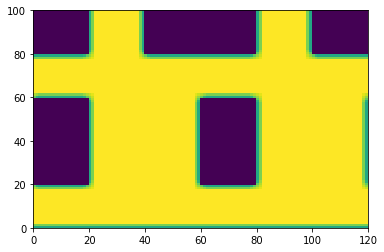

25

In [6]:
conn2_nd = np.empty(mask.shape, np.object)
conn2_nd_cnt = np.zeros(mask.shape, dtype=np.int32)
for ind_nd, maskval in np.ndenumerate(mask):
    conn2_nd[ind_nd] = gen_conn2_nd(mask, ind_nd)
    conn2_nd_cnt[ind_nd] = len(conn2_nd[ind_nd])

plt.pcolormesh(conn2_nd_cnt)
plt.show()

conn2_nd_cnt.max()

# Color vertices/cells using Greedy algorithm

12


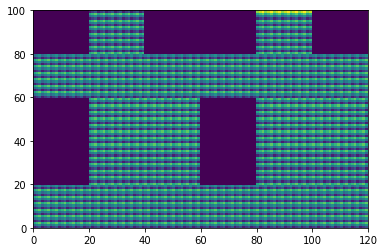

In [7]:
color = np.full(mask.shape, -1)
inds_nd = [ind_nd for ind_nd in np.ndindex(mask.shape) if mask[ind_nd]]
for ind_nd in inds_nd:
    conn2_colors = [
        color[ind2_nd] for ind2_nd in conn2_nd[ind_nd]
    ]
    color_val = 0
    while True:
        if color_val not in conn2_colors:
            break
        color_val += 1
    color[ind_nd] = color_val

print(color.max()+1)

plt.pcolormesh(color)
plt.show()

# for c in range(color.max()+1):
#     plt.pcolormesh(color == c)
#     plt.show()
#     print([c, (color == c).sum()])

# Color vertices/cells using Greedy algorithm, reverse order

12


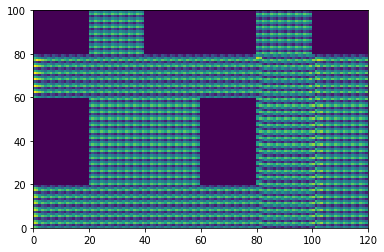

In [8]:
color = np.full(mask.shape, -1)
inds_nd = [ind_nd for ind_nd in np.ndindex(mask.shape) if mask[ind_nd]]
for ind_nd in inds_nd[::-1]:
    conn2_colors = [
        color[ind2_nd] for ind2_nd in conn2_nd[ind_nd]
    ]
    color_val = 0
    while True:
        if color_val not in conn2_colors:
            break
        color_val += 1
    color[ind_nd] = color_val

print(color.max()+1)

plt.pcolormesh(color)
plt.show()

# for c in range(color.max()+1):
#     plt.pcolormesh(color == c)
#     plt.show()
#     print([c, (color == c).sum()])

# Color vertices/cells using greedy algorithm, vertices sorted by degree

13


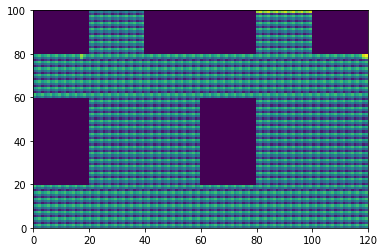

In [9]:
color = np.full(mask.shape, -1)
inds_nd = [ind_nd for ind_nd in np.ndindex(mask.shape) if mask[ind_nd]]
inds_nd.sort(key=lambda ind_nd: len(conn2_nd[ind_nd]), reverse=True)
for ind_nd in inds_nd:
    conn2_colors = [
        color[ind2_nd] for ind2_nd in conn2_nd[ind_nd]
    ]
    color_val = 0
    while True:
        if color_val not in conn2_colors:
            break
        color_val += 1
    color[ind_nd] = color_val

print(color.max()+1)

plt.pcolormesh(color)
plt.show()

# for c in range(color.max()+1):
#     plt.pcolormesh(color == c)
#     plt.show()
#     print([c, (color == c).sum()])

# Color vertices/cells using DSatur algorithm

12


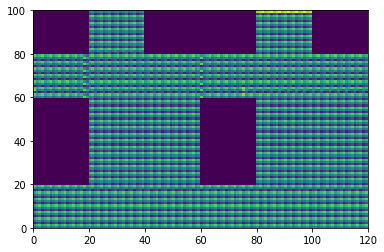

In [10]:
color = np.full(mask.shape, -1)
inds_nd = [ind_nd for ind_nd in np.ndindex(mask.shape) if mask[ind_nd]]
inds_nd.sort(key=lambda ind_nd: len(conn2_nd[ind_nd]), reverse=True)
neighbor_colors = np.empty(mask.shape, np.object)
for ind_nd in np.ndindex(mask.shape):
    neighbor_colors[ind_nd] = set()
neighbor_color_cnt = np.zeros(mask.shape, dtype=np.int32)

while len(inds_nd) > 0:
    # choose vertex to be colored
    ind_nd = max(inds_nd, key=lambda ind_nd: neighbor_color_cnt[ind_nd])
    
    # color with 1st available color
    color_val = 0
    while True:
        if color_val not in neighbor_colors[ind_nd]:
            break
        color_val += 1
    color[ind_nd] = color_val

    # update neighbor colors and color count
    for ind2_nd in conn2_nd[ind_nd]:
        neighbor_colors[ind2_nd].update({color_val})
        neighbor_color_cnt[ind2_nd] = len(neighbor_colors[ind2_nd])
        
    # remove vertex just colored from inds_nd
    inds_nd.remove(ind_nd)

print(color.max()+1)

plt.pcolormesh(color)
plt.show()

# for c in range(color.max()+1):
#     plt.pcolormesh(color == c)
#     plt.show()
#     print([c, (color == c).sum()])

# create arrays to map between nd and 1d indices

8800


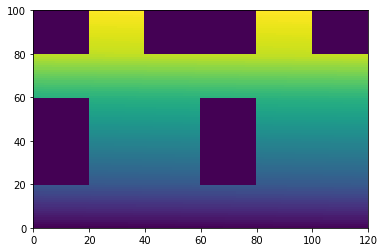

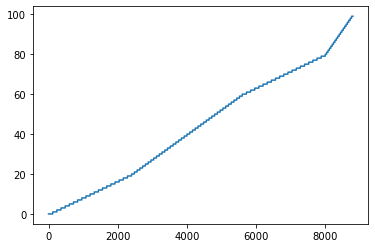

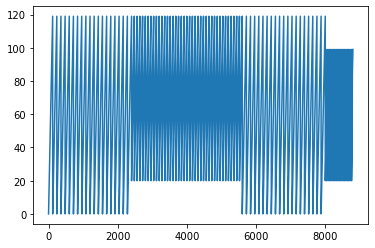

In [11]:
flat_len = int(mask.sum()) # assumes mask is 0 or 1
print(flat_len)
nd_to_flat = np.full(mask.shape, -1, dtype=np.int32)
flat_to_nd = np.empty((flat_len, mask.ndim), dtype=np.int32)

ind_flat = 0
for ind_nd, maskval in np.ndenumerate(mask):
    if maskval:
        nd_to_flat[ind_nd] = ind_flat
        flat_to_nd[ind_flat,:] = ind_nd
        ind_flat += 1

plt.pcolormesh(nd_to_flat)
plt.show()

for dim in range(mask.ndim):
    plt.plot(flat_to_nd[:,dim])
    plt.show()

# write adjacency graph to file, in DIMACS format

In [12]:
# DIMACS format described at
# http://lcs.ios.ac.cn/~caisw/Resource/about_DIMACS_graph_format.txt

with open("./work/graph.txt", mode="w") as fptr:
    fptr.write("c adjacent graph for IRF tracers\n")
    fptr.write(f"p edge {flat_len} {(conn2_nd_cnt.sum()-flat_len)//2}\n")
    inds_nd = [ind_nd for ind_nd in np.ndindex(mask.shape) if mask[ind_nd]]
    for ind_nd in inds_nd:
        ind_flat = nd_to_flat[ind_nd]
        for ind2_nd in conn2_nd[ind_nd]:
            ind2_flat = nd_to_flat[ind2_nd]
            if ind2_flat > ind_flat:
                fptr.write(f"e {ind_flat+1} {ind2_flat+1}\n")


# generate coloring with external program

In [13]:
cwd = "./work"
done = False
checks_lim = 1000000000
while not done:
    print(f"checks_lim = {checks_lim}")
    cmd = ["../../externals/gCol/HybridEA/HybridEA"]
    cmd.extend(["./graph.txt", "-s", f"{checks_lim}", "-T", "9", "-v"])
    output = subprocess.check_output(cmd, cwd=cwd).decode()
    print(output)
    done = "found" in output
    if (not done):
        response = input("enter new checks_lim value, 0 to stop")
        checks_lim = int(response)
        done = (checks_lim == 0)

checks_lim = 1000000000
Hybrid Evolutionary Algorithm using <./graph.txt>

 COLS     CPU-TIME	CHECKS
   13        857ms	163824422 (via constructive)
   12       1542ms	279989274
   11       2318ms	396176790

Run limit exceeded. No solution using 10 colours was achieved (Checks = 1201970314, 4803ms)



enter new checks_lim value, 0 to stop 2000000000


checks_lim = 2000000000
Hybrid Evolutionary Algorithm using <./graph.txt>

 COLS     CPU-TIME	CHECKS
   13        898ms	163824422 (via constructive)
   12       1481ms	279989274
   11       2111ms	396176790
   10       5999ms	1762989239

Run limit exceeded. No solution using 9 colours was achieved (Checks = 2158134999, 7106ms)



enter new checks_lim value, 0 to stop 5000000000


checks_lim = 5000000000
Hybrid Evolutionary Algorithm using <./graph.txt>

 COLS     CPU-TIME	CHECKS
   13        888ms	163824422 (via constructive)
   12       1554ms	279989274
   11       2328ms	396176790
   10       6783ms	1762989239
    9      13128ms	3658101412

Solution with  <=9 colours has been found. Ending...



# read externally generated coloring, verifying that coloring is proper

9


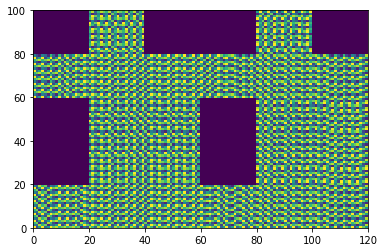

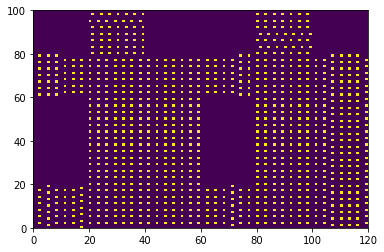

[0, 982]


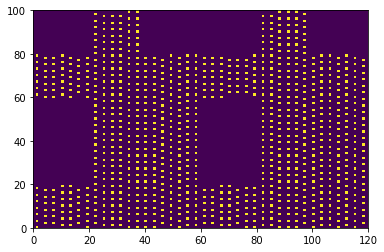

[1, 963]


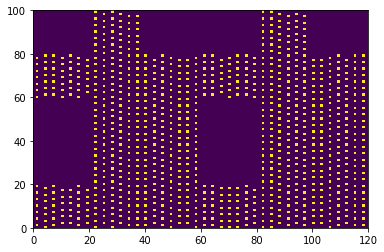

[2, 962]


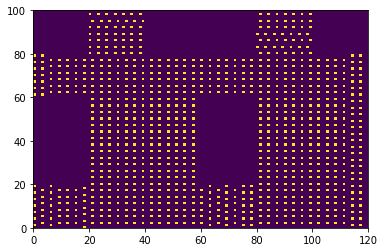

[3, 953]


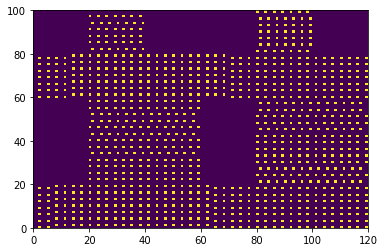

[4, 1006]


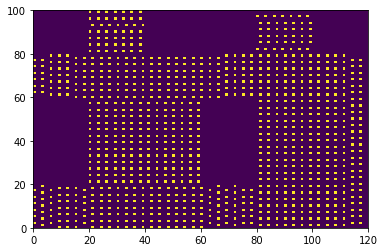

[5, 991]


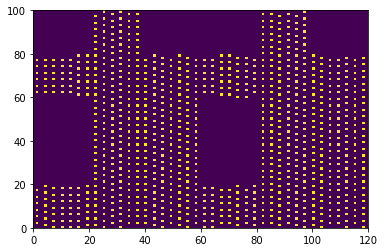

[6, 955]


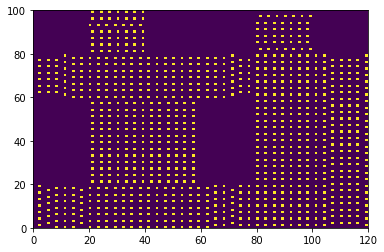

[7, 990]


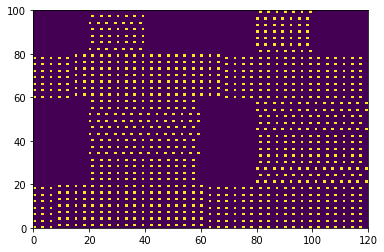

[8, 998]


In [15]:
color = np.full(mask.shape, -1)

with open("./work/solution.txt", mode="r") as fptr:
    skip = fptr.readline()
    for ind_nd in np.ndindex(mask.shape):
        if mask[ind_nd]:
            color[ind_nd] = int(fptr.readline())
            neighbor_colors = [
                color[ind2_nd] for ind2_nd in conn2_nd[ind_nd] if ind2_nd != ind_nd
            ]
            if color[ind_nd] in neighbor_colors:
                print(f"improper coloring at {ind_nd}")

print(color.max()+1)

plt.pcolormesh(color)
plt.show()

for c in range(color.max()+1):
    plt.pcolormesh(color == c)
    plt.show()
    print([c, (color == c).sum()])